In [190]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import sklearn
from sklearn import datasets

features: DataFrame
target: Series
(features, target) = datasets.load_diabetes(return_X_y=True, as_frame=True)
print("Features(head):", features.head(3), sep='\n', end='\n\n')
print("NullCheck:", features.isnull().any(), sep='\n', end='\n\n')
print("Target(head):", target.head(3), sep='\n', end='\n\n')

Features(head):
        age       sex       bmi  ...        s4        s5        s6
0  0.038076  0.050680  0.061696  ... -0.002592  0.019907 -0.017646
1 -0.001882 -0.044642 -0.051474  ... -0.039493 -0.068332 -0.092204
2  0.085299  0.050680  0.044451  ... -0.002592  0.002861 -0.025930

[3 rows x 10 columns]

NullCheck:
age    False
sex    False
bmi    False
bp     False
s1     False
s2     False
s3     False
s4     False
s5     False
s6     False
dtype: bool

Target(head):
0    151.0
1     75.0
2    141.0
Name: target, dtype: float64



In [191]:
correlation = features.corr()
np.fill_diagonal(correlation.to_numpy(), np.NaN)
max_correlated = correlation.abs().idxmax()
corr_values = np.array([correlation.loc[col, max_correlated[col]] for col in correlation.columns])

report = DataFrame({
    'max_corr_feature': max_correlated,
    "corr": corr_values, 
    "abs_corr": abs(corr_values)
})

print('Feature pair correlation:')
print(report.sort_values('abs_corr', ascending=False), '\n')

Feature pair correlation:
    max_corr_feature      corr  abs_corr
s1                s2  0.896663  0.896663
s2                s1  0.896663  0.896663
s3                s4 -0.738493  0.738493
s4                s3 -0.738493  0.738493
s5                s4  0.617859  0.617859
s6                s5  0.464669  0.464669
bmi               s5  0.446157  0.446157
bp               bmi  0.395411  0.395411
sex               s3 -0.379090  0.379090
age               bp  0.335428  0.335428 



In [192]:
data = features.copy()
data['target'] = target

correlation = data.corr()
np.fill_diagonal(correlation.to_numpy(), np.NaN)

print('Target correlation:')
print(correlation['target'].sort_values(key=abs, ascending=False).drop('target'))

Target correlation:
bmi    0.586450
s5     0.565883
bp     0.441482
s4     0.430453
s3    -0.394789
s6     0.382483
s1     0.212022
age    0.187889
s2     0.174054
sex    0.043062
Name: target, dtype: float64


In [193]:
from sklearn.model_selection import train_test_split

REGRESSION_FEATURE = 'bmi'

X = data[[REGRESSION_FEATURE]]
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33
)

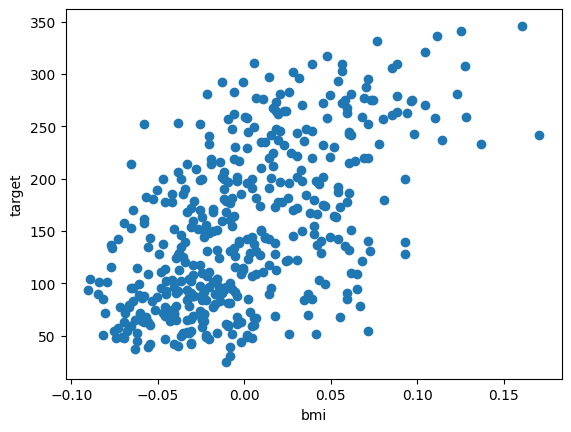

In [194]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot()
ax1.set_xlabel(REGRESSION_FEATURE)
ax1.set_ylabel('target')

ax1.scatter(X, y)
plt.show()

In [195]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [196]:
import sklearn.metrics as sklm
# Lab 1_1
def scoring_procedure(y_true, y_pred, header=''):
    abs_err = abs(y_true - y_pred)
    mse = sklm.mean_squared_error(y_true, y_pred)
    report = f"""
    {header}
    MSE: {mse:.3f}
    RMSE: {np.sqrt(mse):.3f} 
    R2: {sklm.r2_score(y_true, y_pred):.3f}
    MAE: {sklm.mean_absolute_error(y_true, y_pred):.3f}
    MAPE: {sklm.mean_absolute_percentage_error(y_true, y_pred):.3f}
    Min abs err: {np.min(abs_err):.3f}
    Max abs err: {np.max(abs_err):.3f}
    """
    print(report)

In [197]:
sklearn_prediction = model.predict(X_test)
scoring_procedure(y_test, sklearn_prediction, header='Sklearn Regression')


    Sklearn Regression
    MSE: 3919.001
    RMSE: 62.602 
    R2: 0.359
    MAE: 52.445
    MAPE: 0.434
    Min abs err: 0.570
    Max abs err: 157.107
    


In [198]:
# Lab 1_1
def fit_2D_regression(X: np.array, y: np.array) -> tuple[np.float64]:
    N = len(X)
    sum_X, sum_Y = np.sum(X), np.sum(y)
    sum_X2 = np.sum(X**2)
    sum_XY = np.sum(X * y)    

    w = (N * sum_XY - sum_X * sum_Y) / (N * sum_X2 - sum_X**2)
    b = (sum_Y - w * sum_X) / N

    return w, b

# подогнать формат данных
w, b = fit_2D_regression(X_train.to_numpy().ravel(), y_train.to_numpy())
my_predict = lambda x: w*x + b

In [199]:
my_prediction = my_predict(X_test)
scoring_procedure(y_test, my_prediction.to_numpy().ravel(), header='My Regression')


    My Regression
    MSE: 3919.001
    RMSE: 62.602 
    R2: 0.359
    MAE: 52.445
    MAPE: 0.434
    Min abs err: 0.570
    Max abs err: 157.107
    


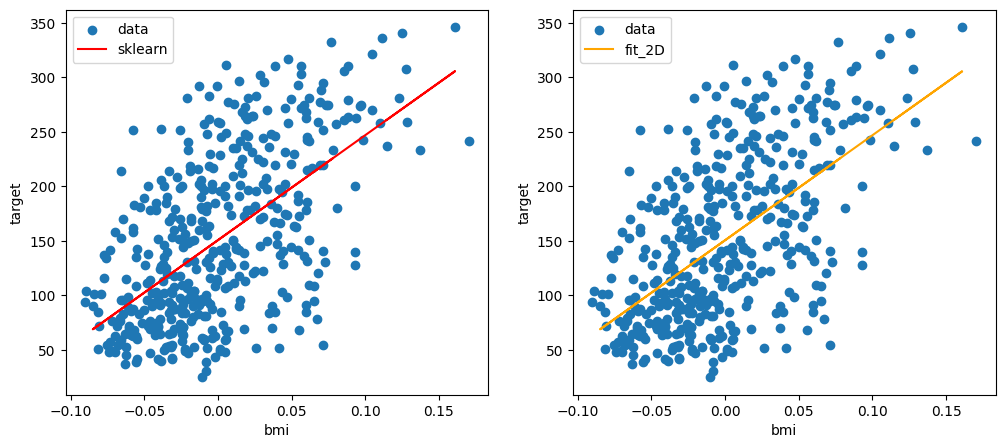

In [200]:
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
for a in (ax1, ax2):
    a.set_xlabel(REGRESSION_FEATURE)
    a.set_ylabel('target')
    a.scatter(X, y, label='data')

ax1.plot(X_test, sklearn_prediction, color='red', label='sklearn')
ax2.plot(X_test, my_prediction, color='orange', label='fit_2D')
ax1.legend()
ax2.legend()

plt.show()

In [201]:
print(f"Sklearn regression: w={model.coef_}  b={model.intercept_}")
print(f"Manual prediction: w={w}  b={b}")

Sklearn regression: w=[962.88582668]  b=150.6833918080658
Manual prediction: w=962.885826677618  b=150.68339180806583


In [202]:
final_table = DataFrame({
    "Target": y,
    "sklearn_prediction": model.predict(X),
    "manual_prediction": my_predict(X.to_numpy().ravel()) 
})
print(final_table.head())
# final_table.to_csv('final_table.csv')

   Target  sklearn_prediction  manual_prediction
0   151.0          210.089795         210.089795
1    75.0          101.119748         101.119748
2   141.0          193.484835         193.484835
3   206.0          139.518717         139.518717
4   135.0          115.649087         115.649087


Дополнительно можно легко проверить гипотезу наличия экспоненциальных зависимостей в данных.  
Достаточно проверить на корреляцию log(X) - при сильной зависимости получим y = w*exp(X) + b экпоненциальную регрессию.

In [203]:
log_data = np.log(features.copy().abs())
log_data['target'] = target

correlation = log_data.corr()
np.fill_diagonal(correlation.to_numpy(), np.NaN)
print('Target correlation:')
print(correlation['target'].sort_values(key=abs, ascending=False).drop('target'))

Target correlation:
bp     0.131249
s6     0.088532
bmi    0.071488
s4    -0.068277
s2     0.065316
s1     0.060124
age    0.046725
sex    0.043062
s3    -0.010933
s5     0.009923
Name: target, dtype: float64


Вывод - экспоненциальных зависимостей не наблюдается